# <center>Case Study: Co-working network at the Itatiaia municipality</center>
## <center>JBRJ species occurrence dataset</center>

#### <center>Author: Pedro Correia de Siracusa</center>
#### <center>Date: Sep 26, 2017</center>

This notebook is a case study with records from the Itatiaia municipality, at the Rio de Janeiro state, Brazil. Created on 1937 by president Getúlio Vargas, the Itatiaia National Park is the oldest national park in Brazil, and was therefore hypothesized to be one of the most thoroughly sampled regions for the JBRJ species occurrence dataset (personal communication from the JBRJ dataset curator and research team). In this notebook I will verify how suitable this subset is for assembling a collectors co-working network. 

The model's quality mostly depends on the quality of the `recordedBy` column, which stores the names of the collectors responsible for each record. Some important quality attributes for this field are:

1) low number of spelling variations for each name. Some variation might exist as a result of names or surnames being misspelled or ommited;

2) standardized structure of collectors' names and delimiters. Ideally, we would require a unique authorship naming standard to be used for the entire dataset, as well as using consistent delimiters for separating entities. [TDWG](http://rs.tdwg.org/dwc/) recommends using the '|' character as the delimiter.

3) inclusion of the names of all collectors responsible for a record, as opposed to including non-primary collectors as *et al.* or simply omitting them;

Moreover, in this notebook I will introduce two new classes for simplifying the routine of building a co-working network from biodiversity occurrene datasets: the `NamesIndex` class and the `CoworkingNetwork` class. I will also reuse some functions which were defined in previous notebooks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

In [2]:
# functions defined on notebook 5

import re
import unicodedata, string

def namesFromString( namesStr, splitOn=';', unique=False, preserveOrder=False ):
    if type(splitOn)==str:
        namesSplit = namesStr.split(splitOn)
        
    elif type(splitOn)==list:
        namesSplit = re.split( '|'.join( c for c in splitOn ) ,namesStr)
    
    namesList = [ n for n in [ name.strip() for name in namesSplit ] if n!='' ]
    
    if unique:
        if not preserveOrder: return list(set(namesList))
        else:
            namesCounts = dict( (n,0) for n in namesList )
            unique_namesList = []
            for n in namesList:
                if namesCounts[n]: continue
                namesCounts[n]+=1
                unique_namesList.append(n)
        return unique_namesList   
    
    return namesList


def normalize(name, normalizationForm='NFKD'):
    name = name.lower() # to lowecase
    name = name.replace('.','') # remove periods
    name_ls = tuple( part.strip() for part in name.split(',') ) # split and strip names into tuples

    normalize = lambda s: ''.join( x for x in unicodedata.normalize(normalizationForm, s) if x in string.ascii_letters ) # remove accents
    name_ls = tuple( normalize(name) for name in name_ls )
    
    return ','.join(name_ls)

---

### The JBRJ occurrence dataset

The dataset used in this case study is the [Rio de Janeiro Botanical Garden Herbarium Collection](http://ipt.jbrj.gov.br/jbrj/resource?r=jbrj_rb), available from the JBRJ [IPT](http://ipt.jbrj.gov.br/jbrj/).

In [3]:
datasetpath = '/home/pedro/datasets/jbrj_herbarium/occurrence.txt'

In [4]:
colnames = ['recordedBy', 'taxonRank', 'scientificName', 'eventDate',
            'occurrenceID', 'collectionCode', 'stateProvince', 
            'locality', 'countryCode', 'county']
occs = pd.read_csv(datasetpath, sep='\t', usecols=colnames)

Here I'm specifically interested in records from the Itatiaia municipality which hold information on the collectors identities. I will therefore filter out records outside the Itatiaia municipality and those for which the `recordedBy` attribute is null. Notice that this dataset is composed by records from multiple institutions, as can be verified by inspecting the `collectionCode` column.

In [5]:
occs_itatiaia = occs[occs['county'].apply(lambda x: 'Itatiaia' in str(x))]
occs_itatiaia = occs_itatiaia[occs_itatiaia['recordedBy'].notnull()]

In [6]:
occs_itatiaia.head(10)

,collectionCode,occurrenceID,recordedBy,eventDate,countryCode,stateProvince,county,locality,scientificName,taxonRank
169,RB,urn:catalog:JBRJ:RB:327442,R.W.Kaempfe,1931-03-03,BR,Rio de Janeiro,Itatiaia,Serra da Mantiqueira.,ROSACEAE Fragaria,genus
225,RB,urn:catalog:JBRJ:RB:379779,P. Campos Porto,1918-08-20,BR,Rio de Janeiro,Itatiaia,Lactiferos.,SAPOTACEAE,family
306,ITA,urn:catalog:JBRJ:RB:477401,José Adaltro Lemes,1977-10-04,BR,Rio de Janeiro,Itatiaia,Macieiras.,SYMPLOCACEAE,family
310,ITA,urn:catalog:JBRJ:RB:478924,J. J. Sampaio,1942-09-25,BR,Rio de Janeiro,Itatiaia,Repouso Itatiaiai.,SOLANACEAE Solanum,genus
408,RUSU,urn:catalog:JBRJ:RB:679739,"Camerik, A.M.",1975-04-23,BR,Rio de Janeiro,Itatiaia,NaN,AQUIFOLIACEAE Ilex,genus
514,RB,urn:catalog:JBRJ:RB:554980,M. Salazar Yepes,NaN,BR,Rio de Janeiro,Itatiaia,"PARNA-Itatiaia, trilha três Picos.",INDETERMINADA,family
517,RB,urn:catalog:JBRJ:RB:560431,M. Salazar Yepes & A.A. Carvalho Jr.,NaN,BR,Rio de Janeiro,Itatiaia,"PARNA-Itatiaia, na estrada Portaria Principal-...",INDETERMINADA,family
705,RB,urn:catalog:JBRJ:RB:1006065,M. Salazar Yepes & A.A. Carvalho Jr.,2007-8-7,BR,Rio de Janeiro,Itatiaia,NaN,PUCCINIALES Phakopsora rossmanii,specie
741,RB,urn:catalog:JBRJ:RB:145779,A. Mello,NaN,BR,Rio de Janeiro,Itatiaia,NaN,LEGUMINOSAE Melanoxylon brauna Schott,specie
1253,ITA,urn:catalog:JBRJ:RB:477461,P. C. Porto,1918,BR,Rio de Janeiro,Itatiaia,NaN,SAPINDACEAE,family


---

## 1. Atomizing names

The first step to obtain names from the dataset is to make them atomic. Let's create a new column named `recordedBy_atomized` which stores lists of collectors' names, as extracted by the `atomizeNames` function below. It takes as arguments a data frame, the name of the column to be atomized, an atomizing function or expression to be applied to non-atomic strings of names, the indexes of the records to be atomized and the name of the column to store atomized names. The dataframe is changed inplace.

In [7]:
def atomizeNames( df, colName, atomizingFunction, recordsIndex=None, atomizedColName=None  ):
    if not atomizedColName:
        atomizedColName = colName+"_atomized"
    
    if recordsIndex:
        df.loc[recordsIndex,atomizedColName] = df.loc[recordsIndex,colName].apply( atomizingFunction )
    else: # atomize the entire dataframe
        df.loc[:,atomizedColName] = df.loc[:,colName].apply( atomizingFunction )

In [8]:
atomizingOperation = lambda ns: namesFromString(ns, splitOn=['&',';',' e ']) 

atomizeNames(occs_itatiaia, 'recordedBy', atomizingOperation)
occs_itatiaia.head()

,collectionCode,occurrenceID,recordedBy,eventDate,countryCode,stateProvince,county,locality,scientificName,taxonRank,recordedBy_atomized
169,RB,urn:catalog:JBRJ:RB:327442,R.W.Kaempfe,1931-03-03,BR,Rio de Janeiro,Itatiaia,Serra da Mantiqueira.,ROSACEAE Fragaria,genus,[R.W.Kaempfe]
225,RB,urn:catalog:JBRJ:RB:379779,P. Campos Porto,1918-08-20,BR,Rio de Janeiro,Itatiaia,Lactiferos.,SAPOTACEAE,family,[P. Campos Porto]
306,ITA,urn:catalog:JBRJ:RB:477401,José Adaltro Lemes,1977-10-04,BR,Rio de Janeiro,Itatiaia,Macieiras.,SYMPLOCACEAE,family,[José Adaltro Lemes]
310,ITA,urn:catalog:JBRJ:RB:478924,J. J. Sampaio,1942-09-25,BR,Rio de Janeiro,Itatiaia,Repouso Itatiaiai.,SOLANACEAE Solanum,genus,[J. J. Sampaio]
408,RUSU,urn:catalog:JBRJ:RB:679739,"Camerik, A.M.",1975-04-23,BR,Rio de Janeiro,Itatiaia,NaN,AQUIFOLIACEAE Ilex,genus,"[Camerik, A.M.]"


Here I'm particularly interested in **collaborative records**, those which were recorded by more than one collector. In order to get them I'll simply count the number of elements in the names list at the `recordedBy_atomized` column for each record. Records with more than one element will be considered collaborative.

In [9]:
occs_itatiaia_collaborative = occs_itatiaia[occs_itatiaia['recordedBy_atomized'].apply(lambda l: len(l)>1)]

As it turns out the percentage of collaborative records for the records at Itatiaia is relatively low:

In [10]:
print("Collaborative records at Itatiaia\n\tTotal number: {};\n\tPercentual: {:.2%}".format(
    occs_itatiaia_collaborative.shape[0],
    occs_itatiaia_collaborative.shape[0]/occs_itatiaia.shape[0]))

Collaborative records at Itatiaia
	Total number: 1192;
	Percentual: 8.03%


Below I get a list of collaborative collectors in Itatiaia. Notice that some names are probably spelling variations of others, and therefore refer to the same entity. For example `'A.A. Carvalho Jr.'` probably refers to the same entity as `'A.A.Carvalho'`. I'll address this issue in the next section, by mapping names variants. By now let's deal with the issue that some records were not properly atomized, as it is the case of `'M. Salazar Yepes, A.A. Carvalho Jr.'` and `'Ed. Pereira, Egle,'`. After all before normalizing and mapping names variations we must ensure that names are atomic, which means they refer to a single entity.

In [11]:
namesList = lambda col: sorted(list(set( n for nlst in col for n in nlst )))
namesList(occs_itatiaia_collaborative['recordedBy_atomized'])

['A. C. Brade',
 'A.A. Carvalho Jr.',
 'A.A.Carvalho',
 'A.C.Mota',
 'Aparicio',
 'Apparicio',
 'Brade',
 'Brade, A. C.',
 'C.M. Sakuragui',
 'D. P. Costa',
 'D.P.Costa',
 'Ed. Pereira, Egle,',
 'Edmundo',
 'F. Santoro',
 'F. Toledo Jr.',
 'Fidalgo, K.',
 'Fidalgo, O.',
 'Fildalgo',
 'G. Martinelli',
 'Graziela',
 'I. França',
 'K.Fidalgo',
 'Kauffmann Fidalfo Eg-07',
 'Kauffmann Fidalgo',
 'L. C. S. Giordano',
 'L. S. Sylvestre',
 'L.A.F',
 'Lanstsyak, L.',
 'Lanstyak, L.',
 'Luiz',
 'M. Barros',
 'M. Salazar Yepes',
 'M. Salazar Yepes, A.A. Carvalho Jr.',
 'M.D.M.Vianna Filho 2020',
 'M.E. Kauffmann Fidalgo',
 'M.P.M. de Lima',
 'M.Salazar Yepes',
 'O. Fidalgo',
 'O.Fidalgo',
 'O.fidalgo',
 'Occhioni, P.',
 'Oswaldo Fidalgo',
 'P.J.L. Maas',
 'P.J.M. Maas',
 'Prof Pilger',
 'S. R. Gradstein',
 'S. Salgado',
 'S.R.Gradstein',
 'Santos Filho',
 'Silveira Melo, O.',
 'Silveira, O.',
 'Tamandaré',
 'Tamandaré de Toledo',
 'Toledo']

### 1.1 Reatomizing some of the names

The routine below selectively reatomizes records for which collector names are included in the `namesToReatomize` list. This is performed by applying another **atomization rule** (the `atomizeName` operation below) to the previously atomized `recordedBy_atomized` field of the target records.

In [12]:
namesToReatomize = [ 'M. Salazar Yepes, A.A. Carvalho Jr.', 'Ed. Pereira, Egle,']

atomizeName = lambda n: namesFromString(n, splitOn=',') 
atomizeRow = lambda r: [n for nl in ( atomizeName(n) if n in namesToReatomize else [n] for n in r ) for n in nl ]

occs_itatiaia['recordedBy_atomized'] = occs_itatiaia['recordedBy_atomized'].apply(atomizeRow)

Now we must refilter the collaborative records

In [13]:
occs_itatiaia_collaborative = occs_itatiaia[occs_itatiaia['recordedBy_atomized'].apply(lambda l: len(l)>1)]

And check the new names list

In [14]:
namesList = lambda col: sorted(list(set( n for nlst in col for n in nlst )))
namesList(occs_itatiaia_collaborative['recordedBy_atomized'])

['A. C. Brade',
 'A.A. Carvalho Jr.',
 'A.A.Carvalho',
 'A.C.Mota',
 'Aparicio',
 'Apparicio',
 'Brade',
 'Brade, A. C.',
 'C.M. Sakuragui',
 'D. P. Costa',
 'D.P.Costa',
 'Ed. Pereira',
 'Edmundo',
 'Egle',
 'F. Santoro',
 'F. Toledo Jr.',
 'Fidalgo, K.',
 'Fidalgo, O.',
 'Fildalgo',
 'G. Martinelli',
 'Graziela',
 'I. França',
 'K.Fidalgo',
 'Kauffmann Fidalfo Eg-07',
 'Kauffmann Fidalgo',
 'L. C. S. Giordano',
 'L. S. Sylvestre',
 'L.A.F',
 'Lanstsyak, L.',
 'Lanstyak, L.',
 'Luiz',
 'M. Barros',
 'M. Salazar Yepes',
 'M.D.M.Vianna Filho 2020',
 'M.E. Kauffmann Fidalgo',
 'M.P.M. de Lima',
 'M.Salazar Yepes',
 'O. Fidalgo',
 'O.Fidalgo',
 'O.fidalgo',
 'Occhioni, P.',
 'Oswaldo Fidalgo',
 'P.J.L. Maas',
 'P.J.M. Maas',
 'Prof Pilger',
 'S. R. Gradstein',
 'S. Salgado',
 'S.R.Gradstein',
 'Santos Filho',
 'Silveira Melo, O.',
 'Silveira, O.',
 'Tamandaré',
 'Tamandaré de Toledo',
 'Toledo']

### 1.2 Joining improperly atomized names

It might also be the case that some of the names in the atomized names column should not have been split. The name `'L.A.F'` for example might be actually name initials improperly separated from the last name with a semicolon character, which was used as a delimiter during the atomization process:

In [15]:
occs_itatiaia[occs_itatiaia['recordedBy_atomized'].apply(lambda names: 'L.A.F' in names )]

,collectionCode,occurrenceID,recordedBy,eventDate,countryCode,stateProvince,county,locality,scientificName,taxonRank,recordedBy_atomized
64066,RB,urn:catalog:JBRJ:RB:573945,L.A.F; Santos Filho,2009-09-21,BR,Rio de Janeiro,Itatiaia,Em fragmento florestal no Alto dos Brejos. Par...,MELASTOMATACEAE Tibouchina,genus,"[L.A.F, Santos Filho]"


This record might actually be referring to an entity named 'L.A.F. Santos Filho'. The `joinNames` routine below can be used to fix these cases:

In [16]:
from copy import deepcopy

def joinNames(r, names):
    
    all_names_in_record = all( (n in r) for ntpl in names for n in ntpl )
    
    if all_names_in_record:
        l = deepcopy(r)
        for nametuple in names:
            for part in nametuple:
                l.remove(part)
            l.append(",".join(nametuple))
    else:
        l = r
    return l
                
        

namesToJoin = [("L.A.F", "Santos Filho")]
occs_itatiaia['recordedBy_atomized'] = occs_itatiaia['recordedBy_atomized'].apply( joinNames, names=namesToJoin)

In [17]:
occs_itatiaia['recordedBy_atomized'].loc[64066]

['L.A.F,Santos Filho']

Note that as the single record by 'L.A.F, Santos Filho' is not collaborative anymore, it must be removed from the `occs_itatiaia_collaborative` set. For that I'll reselect collaborative records again.

In [18]:
occs_itatiaia_collaborative = occs_itatiaia[occs_itatiaia['recordedBy_atomized'].apply(lambda l: len(l)>1)]
namesList = lambda col: sorted(list(set( n for nlst in col for n in nlst )))
namesList(occs_itatiaia_collaborative['recordedBy_atomized'])

['A. C. Brade',
 'A.A. Carvalho Jr.',
 'A.A.Carvalho',
 'A.C.Mota',
 'Aparicio',
 'Apparicio',
 'Brade',
 'Brade, A. C.',
 'C.M. Sakuragui',
 'D. P. Costa',
 'D.P.Costa',
 'Ed. Pereira',
 'Edmundo',
 'Egle',
 'F. Santoro',
 'F. Toledo Jr.',
 'Fidalgo, K.',
 'Fidalgo, O.',
 'Fildalgo',
 'G. Martinelli',
 'Graziela',
 'I. França',
 'K.Fidalgo',
 'Kauffmann Fidalfo Eg-07',
 'Kauffmann Fidalgo',
 'L. C. S. Giordano',
 'L. S. Sylvestre',
 'Lanstsyak, L.',
 'Lanstyak, L.',
 'Luiz',
 'M. Barros',
 'M. Salazar Yepes',
 'M.D.M.Vianna Filho 2020',
 'M.E. Kauffmann Fidalgo',
 'M.P.M. de Lima',
 'M.Salazar Yepes',
 'O. Fidalgo',
 'O.Fidalgo',
 'O.fidalgo',
 'Occhioni, P.',
 'Oswaldo Fidalgo',
 'P.J.L. Maas',
 'P.J.M. Maas',
 'Prof Pilger',
 'S. R. Gradstein',
 'S. Salgado',
 'S.R.Gradstein',
 'Silveira Melo, O.',
 'Silveira, O.',
 'Tamandaré',
 'Tamandaré de Toledo',
 'Toledo']

Now that the names are properly atomized, we can address the names variants issue. For that we'll build a **names map**, which maps variations of a name to its unique **normal form**.

---

## 2. The Names Map

The names map will be defined as a *Python* class. When instantiated, the class constructor builds a names dictionary by applying the normalization function to each name in the list. Both the names map and the normalization function are stored as attributes of the `NamesMap` object. As the user inspects the resulting names map she is supposed to identify and indicate names variations which should be mapped to the same entity. The user can then call the object's `remap` method, passing a dictionary which is then stored as a **remapping dictionary**, also an attribute of the `NamesMap` object. The remapping is only applied to the names map when the public `getMap` method is called. This way the names map can be continuously updated without the need of performing the remapping routine over again.

In [19]:
from copy import deepcopy

class NamesMap:
    _map=None
    _normalizationFunction=None
    _remappingDict=None
    
    def __init__(self, names, normalizationFunction):
        self._normalizationFunction = normalizationFunction
        self._map = dict( (n, self._normalizationFunction(n)) for n in names )
        return
    
    def clearMap(self):
        self._map={}
        return
    
    def remap(self, remappingDict):
        if self._remappingDict is None:
            self._remappingDict = remappingDict
        else:
            self._remappingDict.update(remappingDict)
        return     
    
    def insertNames(self, names, normalizationFunction=None, rebuild=False):
        # if rebuild is true, the entire map (but not the remapping dict) is rebuilt from scratch
        if rebuild==True:
            self.clearMap()
        if normalizationFunction is None: 
            normalizationFunction = self._normalizationFunction
        self._map.update( dict( (n,normalizationFunction(n)) for n in names ) )
        return
    
    def getMap(self, remap=True):
        # Returns a COPY of the map
        # If remap is set to true, some remapping occurrs
        res = deepcopy(self._map)
        if remap and self._remappingDict is not None:
            getNamesPrimitives = lambda n: ( name for name,norm in self._map.items() if norm == n )
            for n,t in ( (n,t) for s,t in self._remappingDict.items() for n in getNamesPrimitives(s) ):
                res[n]=t
        return res
    
    def getNormalizedNames(self, remap=True):
        return sorted(list(set(self.getMap(remap=remap).values())))
    
    def getNamePrimitives(self, n):
        nmap = self.getMap()
        return [ name for name,norm in nmap.items() if norm == n ]
        

Let's create our names map. I'll use the `normalize` function from notebook 5 to get names' normal forms.

In [20]:
nm = NamesMap( namesList(occs_itatiaia_collaborative['recordedBy_atomized']), normalize )
nm.getMap()

{'A. C. Brade': 'acbrade',
 'A.A. Carvalho Jr.': 'aacarvalhojr',
 'A.A.Carvalho': 'aacarvalho',
 'A.C.Mota': 'acmota',
 'Aparicio': 'aparicio',
 'Apparicio': 'apparicio',
 'Brade': 'brade',
 'Brade, A. C.': 'brade,ac',
 'C.M. Sakuragui': 'cmsakuragui',
 'D. P. Costa': 'dpcosta',
 'D.P.Costa': 'dpcosta',
 'Ed. Pereira': 'edpereira',
 'Edmundo': 'edmundo',
 'Egle': 'egle',
 'F. Santoro': 'fsantoro',
 'F. Toledo Jr.': 'ftoledojr',
 'Fidalgo, K.': 'fidalgo,k',
 'Fidalgo, O.': 'fidalgo,o',
 'Fildalgo': 'fildalgo',
 'G. Martinelli': 'gmartinelli',
 'Graziela': 'graziela',
 'I. França': 'ifranca',
 'K.Fidalgo': 'kfidalgo',
 'Kauffmann Fidalfo Eg-07': 'kauffmannfidalfoeg',
 'Kauffmann Fidalgo': 'kauffmannfidalgo',
 'L. C. S. Giordano': 'lcsgiordano',
 'L. S. Sylvestre': 'lssylvestre',
 'Lanstsyak, L.': 'lanstsyak,l',
 'Lanstyak, L.': 'lanstyak,l',
 'Luiz': 'luiz',
 'M. Barros': 'mbarros',
 'M. Salazar Yepes': 'msalazaryepes',
 'M.D.M.Vianna Filho 2020': 'mdmviannafilho',
 'M.E. Kauffmann Fidal

Now we can perform some remapping. Notice, for example, that `'aacarvalhojr'` and `'aacarvalho'` must be remapped to the same normal name, which I'll arbitrarily choose to be the latter. Below I define my remapping dictionary and pass it to my names map's `remap()` method.

In [21]:
remappingDict = {
    'aacarvalhojr': 'aacarvalho',
    'aparicio': 'apparicio',
    'brade': 'brade,ac',
    'fidalgo,k': 'kauffmannfidalgo',
    'fildalgo': 'oswaldofidalgo',
    'fidalgo': 'oswaldofidalgo',
    'kauffmannfidalfoeg': 'kauffmannfidalgo',
    'mekauffmannfidalgo': 'kauffmannfidalgo',
    'kfidalgo': 'kauffmannfidalgo',
    'lanstsyak,l': 'lanstyak,l',
    'fidalgo,o': 'oswaldofidalgo',
    'ofidalgo': 'oswaldofidalgo',
    'silveira,o': 'silveiramelo,o',
    'tamandare': 'tamandaredetoledo',
    'toledo': 'tamandaredetoledo',
    'pjmmaas': 'pjmaas',
    'pjlmaas': 'pjmaas',
    'acbrade': 'brade,ac',
}
nm.remap(remappingDict)
nm.remap({'profpilger':'pilger'}) # remapping dicts can be updated many times...

Now compare the remapped names map below with the original one.

In [22]:
nm.getMap()

{'A. C. Brade': 'brade,ac',
 'A.A. Carvalho Jr.': 'aacarvalho',
 'A.A.Carvalho': 'aacarvalho',
 'A.C.Mota': 'acmota',
 'Aparicio': 'apparicio',
 'Apparicio': 'apparicio',
 'Brade': 'brade,ac',
 'Brade, A. C.': 'brade,ac',
 'C.M. Sakuragui': 'cmsakuragui',
 'D. P. Costa': 'dpcosta',
 'D.P.Costa': 'dpcosta',
 'Ed. Pereira': 'edpereira',
 'Edmundo': 'edmundo',
 'Egle': 'egle',
 'F. Santoro': 'fsantoro',
 'F. Toledo Jr.': 'ftoledojr',
 'Fidalgo, K.': 'kauffmannfidalgo',
 'Fidalgo, O.': 'oswaldofidalgo',
 'Fildalgo': 'oswaldofidalgo',
 'G. Martinelli': 'gmartinelli',
 'Graziela': 'graziela',
 'I. França': 'ifranca',
 'K.Fidalgo': 'kauffmannfidalgo',
 'Kauffmann Fidalfo Eg-07': 'kauffmannfidalgo',
 'Kauffmann Fidalgo': 'kauffmannfidalgo',
 'L. C. S. Giordano': 'lcsgiordano',
 'L. S. Sylvestre': 'lssylvestre',
 'Lanstsyak, L.': 'lanstyak,l',
 'Lanstyak, L.': 'lanstyak,l',
 'Luiz': 'luiz',
 'M. Barros': 'mbarros',
 'M. Salazar Yepes': 'msalazaryepes',
 'M.D.M.Vianna Filho 2020': 'mdmviannafilh

---

## 3. The Names Index

The **names index** is simply a dictionary which associates each normalized name to a list of the ids of the rows where it appears. To build the names indexes we must pass to the function below the dataframe, the column where the atomized names are stored and a names map. If no names map is passed the names index is built using the non-normalized version of the names instead. Using the names index is an alternative for building dummy variables for each name, which would result in a large sparse matrix.

In [23]:
def getNamesIndexes( df, atomizedNamesCol, namesMap=None ):
    # split_names_col is a column with names already split
    namesIndexes = dict( (name,[]) for name in namesMap.values() )
    for i,names in df[atomizedNamesCol].iteritems():
        for name in names:
            if namesMap is not None:
                try:
                    namesIndexes[namesMap[name]].append(i)
                except KeyError:
                    pass
            else:
                namesIndexes[name].append(i)
            
    return namesIndexes

In [24]:
ni = getNamesIndexes(occs_itatiaia_collaborative, 'recordedBy_atomized', nm.getMap())

If we wanted to get the records for the normalized name `'kauffmannfidalgo'` for example we could use the names index for locating the rows:

In [25]:
occs_itatiaia_collaborative.loc[ni['kauffmannfidalgo']].head()

,collectionCode,occurrenceID,recordedBy,eventDate,countryCode,stateProvince,county,locality,scientificName,taxonRank,recordedBy_atomized
441307,RB,urn:catalog:JBRJ:RB:607191,"Fidalgo, O. & Fidalgo, K.",1955-9-4,BR,Rio de Janeiro,Itatiaia,Parque Nacional de Itatiaia. Próximo à Sede do...,POLYPODIACEAE Cochlidium serrulatum (Sw.) L.E....,specie,"[Fidalgo, O., Fidalgo, K.]"
497523,RB,urn:catalog:JBRJ:RB:684741,Fildalgo & Kauffmann Fidalfo Eg-07,1955-09-06,BR,Rio de Janeiro,Itatiaia,Km 4. Itatiaia.,POLYTRICHACEAE Oligotrichum riedelianum (Mont....,specie,"[Fildalgo, Kauffmann Fidalfo Eg-07]"
582213,RB,urn:catalog:JBRJ:RB:996778,O.Fidalgo; K.Fidalgo,1955-9-3,BR,Rio de Janeiro,Itatiaia,P.N.Itatiaia.,POLYPORALES Fomes,genus,"[O.Fidalgo, K.Fidalgo]"
590494,RB,urn:catalog:JBRJ:RB:959963,Oswaldo Fidalgo e M.E. Kauffmann Fidalgo,1955-9-8,BR,Rio de Janeiro,Itatiaia,Próx/ à sede do Parque Nacional do Itatiaia.,ARTHONIALES Chiodecton,genus,"[Oswaldo Fidalgo, M.E. Kauffmann Fidalgo]"
596907,RB,urn:catalog:JBRJ:RB:996920,O. Fidalgo; K.Fidalgo,1955-9-12,BR,Rio de Janeiro,Itatiaia,"Picada Barbosa Rodrigues, P.N.Itatiaia.",RUSSULALES Stereum ostrea (Blume & T.Nees) Fr.,specie,"[O. Fidalgo, K.Fidalgo]"


Next I use the `recordedBy_atomized` column to retrieve collectors collaborations from the data frame. These entities and collaboration relationships will finally be used to build the co-working network.

---

## 4. The Coworking Network

The `CoworkingNetwork` class, which extends the `Graph` class from the `networkx` library, will be defined to represent collectors co-working networks. The constructor takes a set of names sets, which are included as nodes. Cliques are built from nodes that are on common sets. The coworking network can be represented either as a weighted or non-weighted graph. 

In [26]:
import networkx
import itertools
from collections import Counter

class CoworkingNetwork(networkx.Graph):
    """
    Class for coworking networks. Extends networkx Graph class.
    
    Parameters
    ----------
    namesSets : iterable
        An iterable of iterables containing names used to compose cliques 
        in the network.

    weighted : bool, default False
        If set to True the resulting network will have weighted edges
        
    Examples
    --------
    >>> namesSets = [ ['a','b','c'], ['d','e'], ['a','c'] ]
    >>> CoworkingNetwork( namesSets, weighted=True).edges(data=True)
    [('b', 'a', {'weight': 1}),
     ('b', 'c', {'weight': 1}),
     ('a', 'c', {'weight': 2}),
     ('e', 'd', {'weight': 1})]
    
    >>> CoworkingNetwork( namesSets ).edges(data=True)
    [('b', 'a', {}), 
     ('b', 'c', {}), 
     ('a', 'c', {}), 
     ('e', 'd', {})]
    """
    def __init__(self, namesSets, weighted=False):
        super().__init__()
        cliques = map( lambda n: itertools.combinations(n,r=2), namesSets )
        edges = [ e for edges in cliques for e in edges ]
        self.add_edges_from(edges)
        
        if weighted:
            edges_weights = Counter(edges)

            for (u,v),w in edges_weights.items():
                try:
                    self[u][v]['weight'] += w
                except:
                    self[u][v]['weight'] = w        
        return

In [27]:
m = nm.getMap()
names = ([ m[n] for n in names ] for names in occs_itatiaia_collaborative['recordedBy_atomized'])
G = CoworkingNetwork( names, weighted=True)

Below I define a new node attribute `n_records`, which stores, for each collector, the total number of records she has obtained at Itatiaia.

In [28]:
nrecords = dict( (n,len(ix)) for n,ix in getNamesIndexes(occs_itatiaia,'recordedBy_atomized',m).items() )
nx.set_node_attributes(G, 'n_records',nrecords)

In [29]:
nx.write_gexf(G,'./graph.gexf')

Below I list the collectors associated to their total number of records

In [30]:
sorted(tuple(G.nodes(data=True)), key=lambda x: x[1]['n_records'], reverse=True )

[('msalazaryepes', {'n_records': 1215}),
 ('aacarvalho', {'n_records': 1149}),
 ('brade,ac', {'n_records': 911}),
 ('ifranca', {'n_records': 161}),
 ('oswaldofidalgo', {'n_records': 110}),
 ('dpcosta', {'n_records': 103}),
 ('fsantoro', {'n_records': 100}),
 ('cmsakuragui', {'n_records': 79}),
 ('mpmdelima', {'n_records': 67}),
 ('kauffmannfidalgo', {'n_records': 42}),
 ('lanstyak,l', {'n_records': 41}),
 ('apparicio', {'n_records': 37}),
 ('luiz', {'n_records': 37}),
 ('tamandaredetoledo', {'n_records': 34}),
 ('gmartinelli', {'n_records': 26}),
 ('edpereira', {'n_records': 25}),
 ('srgradstein', {'n_records': 21}),
 ('occhioni,p', {'n_records': 15}),
 ('pjmaas', {'n_records': 14}),
 ('graziela', {'n_records': 4}),
 ('ftoledojr', {'n_records': 4}),
 ('edmundo', {'n_records': 3}),
 ('pilger', {'n_records': 3}),
 ('silveiramelo,o', {'n_records': 2}),
 ('lssylvestre', {'n_records': 2}),
 ('egle', {'n_records': 1}),
 ('mdmviannafilho', {'n_records': 1}),
 ('acmota', {'n_records': 1}),
 ('

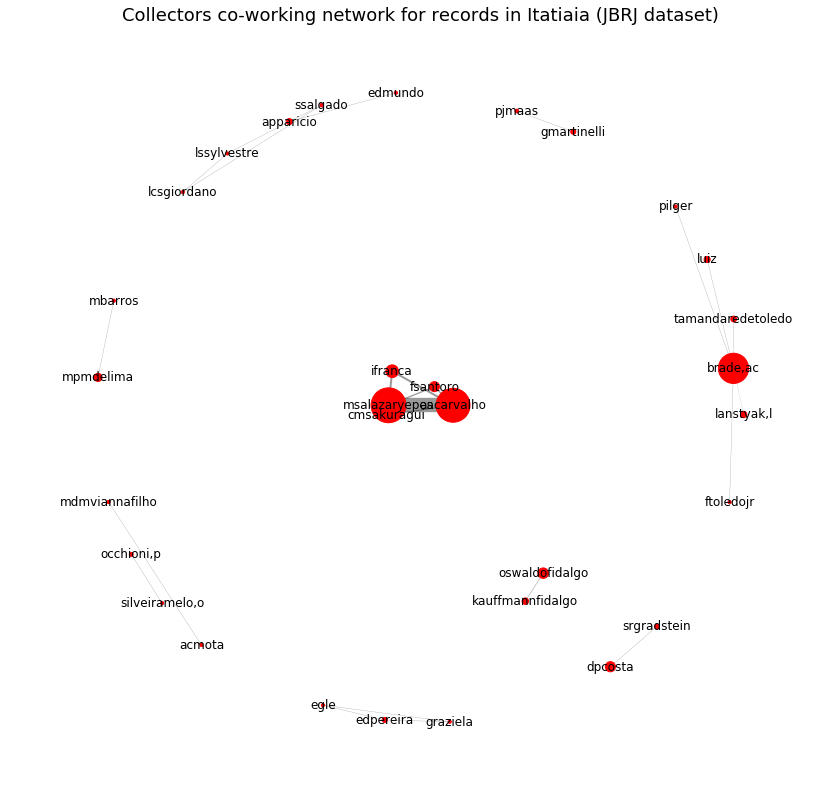

In [31]:
lt = nx.layout.spring_layout(G)
pos = {
 'msalazaryepes': (0.45,0.5),
 'aacarvalho': (0.55,0.5)
}
lt.update(pos)

edges = G.edges()
edges_weights = [ G.edge[u][v]['weight'] for u,v in edges ]
nodes = G.nodes()
nodes_sizes = [ G.node[n]['n_records'] for n in nodes ]

plt.figure(figsize=(14,14))
plt.title('Collectors co-working network for records in Itatiaia (JBRJ dataset)', fontsize=18)
plt.axis('off')
nx.draw_networkx_nodes(G, lt, nodes, node_size=[10 if s<=10 else s for s in nodes_sizes])
nx.draw_networkx_labels(G, lt, font_color='k')
nx.draw_networkx_edges(G, lt, edges, width=[ 0.3 if w<=10 else w/80 for w in edges_weights], alpha=0.4 )

plt.show()

**Figure 1. Collectors co-working network assembled with collaborative records at the Itatiaia municipality, Rio de Janeiro, Brazil. Records from the JBRJ species occurrence dataset.**

---

The resulting network in *Figure 1* apparently does not have sufficient size and structure for drawing any relevant inferences about collectors relationships and collaborations. This was probably due to the low percentage of collaborative records in this subset, as almost 92% of the records were only associated to a single collector. However that does not necessarily correspond to the reality. Although a whole team of collectors might be involved in field expeditions, maybe it is a common practice only to include the first collector's name in the records. Moreover, the `recordedBy` field is usually not important for most users of biodiversity occurrence data, and thus not much effort is expected to having been made for improving this column's quality. It might turn out to be hard to find suitable datasets for modeling collectors co-working networks. 